In [1]:
import jax
from jax import config
config.update("jax_enable_x64",True)

import jax.numpy as jnp
from matplotlib import pyplot as plt
import celmech as cm

import sys
sys.path.append("../01_code")


In [2]:
from staeckel_utils import Rz_lims_to_actions_and_frequencies, Rz_lims_to_ics
from staeckel_utils import Rz_lims_to_ELsqI3
from staeckel_utils import L_to_Rc

In [3]:
Ne = 0.5
def Fsoft(x,e,eps=0.01):
    bsq = 1-e*e
    return -1 * jnp.sqrt(x - bsq * (1 - eps) ) * jnp.arctan(jnp.sqrt(x/bsq - 1 + eps))
Fargs = (Ne,)
Ne = 0.5
# actions,freqs = Rz_lims_to_actions_and_frequencies(4,5,0.15,Ne,Fsoft,Fargs) 
# state0,L0= Rz_lims_to_ics(4.9,5,0.15,Ne,Fsoft,Fargs,z0 = 0.1) 
# R0,z0,pR0,pz0=state0

In [4]:
import numpy as np

In [5]:
from scipy.optimize import root_scalar
Nic = 15
actions,freqs = np.zeros((2,Nic,3))
ics = np.zeros((Nic,4))
Lsq0 = Rz_lims_to_ELsqI3(4.9,5,0.3,Ne,Fsoft,Fargs)[1]
for i,zmax in enumerate(np.linspace(0.05,0.3,Nic,endpoint=False)):
    f = lambda q: Rz_lims_to_ELsqI3(q,5,zmax,Ne,Fsoft,Fargs)[1] - Lsq0
    root = root_scalar(f,bracket=[3,4.99])
    actions[i],freqs[i] = Rz_lims_to_actions_and_frequencies(root.root,5,zmax,Ne,Fsoft,Fargs)
    ics[i],_ = Rz_lims_to_ics(root.root,5,zmax,Ne,Fsoft,Fargs,z0 = 0.01) 

L0 = actions[0,2]

In [6]:
zmax = np.linspace(0.05,0.3,Nic,endpoint=False)

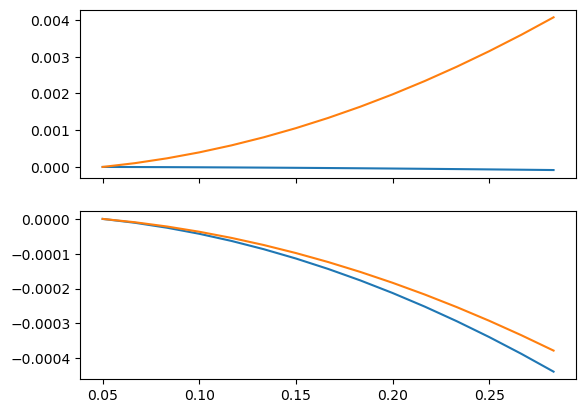

In [9]:
fig,ax = plt.subplots(2,1,sharex=True)
ax[0].plot(zmax,actions[:,0]-actions[0,0] )
ax[0].plot(zmax,actions[:,1]-actions[0,1])
ax[1].plot(zmax,freqs[:,0]-freqs[0,0])
ax[1].plot(zmax,freqs[:,1]-freqs[0,1])

In [10]:
Rc = L_to_Rc(4.9,L0,Ne,Fsoft,Fargs)

In [11]:
from staeckel_utils import R_z_to_lambda_mu
def staeckel_Phi_eff(Rz,L,e,F,Fargs):
    R,z = Rz
    esq = e*e
    D = esq*esq + 2 * esq * (R*R - z*z) + (R*R+z*z)**2
    lmbda = (2 - esq + R*R + z*z + jnp.sqrt(D))/2
    mu = (2 - esq + R*R + z*z - jnp.sqrt(D))/2
    return 0.5*L*L/R/R + (F(lmbda,*Fargs) - F(mu,*Fargs)) / (lmbda-mu)

In [12]:
from potentials_autodiff import get_derivs, PotentialDerivativesToPoissonSeries

In [13]:
Nmax = 4
x0 = jnp.array((Rc,0))
Phi = lambda x: staeckel_Phi_eff(x,float(L0),Ne,Fsoft,Fargs)
deriv_dict = get_derivs(Phi,x0,Nmax)
deriv_dict = {key:float(val) for key,val in deriv_dict.items()}
pseries = PotentialDerivativesToPoissonSeries(deriv_dict,Nmax)

In [14]:
from celmech.poisson_series_manipulate import PoissonSeries, do_perturbation_theory, PSTerm

In [15]:
import numpy as np

In [16]:
kappa,nu = np.sqrt(deriv_dict[(2,0)]),np.sqrt(deriv_dict[(0,2)])
chi,Hav,_ = do_perturbation_theory(np.array((kappa,nu)),pseries,Nmax)

In [17]:
from collections import defaultdict
from celmech.poisson_series_manipulate import expL,expLinv, bracket
def soln(ics,kappa,nu,Hav,chi):
    
    xR_series,xz_series = [ defaultdict(lambda: PoissonSeries(2,0)) for _ in range(2)]
    xR_series[1]=PoissonSeries.from_PSTerms([PSTerm(1,[1,0],[0,0],[],[])])
    xz_series[1]=PoissonSeries.from_PSTerms([PSTerm(1,[0,1],[0,0],[],[])])
    
    Htot = PoissonSeries(2,0)
    for order,val in Hav.items():
        Htot+= val
        
    xR_transformed = PoissonSeries(2,0)
    for order,val in expLinv(xR_series,chi).items():
        xR_transformed += val
    xz_transformed = PoissonSeries(2,0)
    for order,val in expLinv(xz_series,chi).items():
        xz_transformed += val
    
    xR_dot_series = bracket(xR_series[1],Htot)
    xz_dot_series = bracket(xz_series[1],Htot)    
    actions, freqs = np.zeros((2,len(ics),2))
    for i,ic in enumerate(ics):
        R0,z0,pR0,pz0 = ic
        xR0 = np.sqrt(0.5*kappa) * ( (R0-Rc) + 1j * pR0/kappa)
        xz0 = np.sqrt(0.5*nu) * ( z0 + 1j * pz0/nu)
        xR1 = xR_transformed([xR0,xz0],[],[])
        xz1 = xz_transformed([xR0,xz0],[],[])
        Omega_R = -1 * np.imag(xR_dot_series([xR1,xz1],[],[]) / xR1)
        Omega_z = -1 * np.imag(xz_dot_series([xR1,xz1],[],[]) / xz1)
        freqs[i] = np.array((Omega_R,Omega_z))
        actions[i] = np.real(( xR1 * np.conjugate(xR1),xz1 * np.conjugate(xz1) ))
        
        
    return actions,freqs

In [18]:
omega0=jnp.array((np.real(kappa),np.real(nu)))
pert_actions,pert_freqs = soln(ics,kappa,nu,Hav,chi)


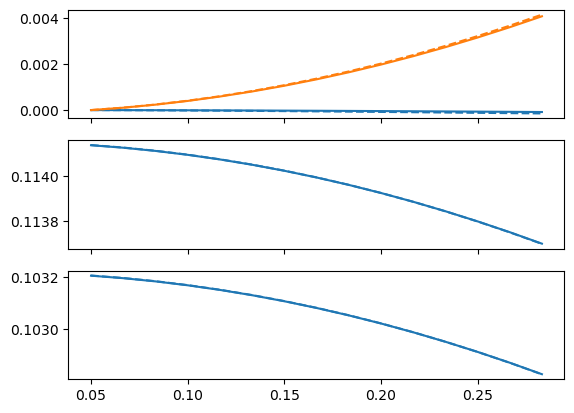

In [19]:
fig,ax = plt.subplots(3,1,sharex=True)
l,=ax[0].plot(zmax,actions[:,0]-actions[0,0] )
ax[0].plot(zmax,pert_actions[:,0]-pert_actions[0,0],color=l.get_color(),ls='--')
l,=ax[0].plot(zmax,actions[:,1]-actions[0,1] )
ax[0].plot(zmax,pert_actions[:,1]-pert_actions[0,1],color=l.get_color(),ls='--')



l,=ax[1].plot(zmax,freqs[:,0] )
ax[1].plot(zmax,pert_freqs[:,0],color=l.get_color(),ls='--')

l,=ax[2].plot(zmax,freqs[:,1] )
ax[2].plot(zmax,pert_freqs[:,1],color=l.get_color(),ls='--')

# l,=ax[1].plot(zmax,actions[:,1]-actions[0,1] )
# ax[1].plot(zmax,pert_actions[:,1]-pert_actions[0,1],color=l.get_color(),ls='--')
